In [14]:
from collections import defaultdict, Counter
from itertools import zip_longest
import json
import os
import re
import sys
import urllib

import numpy as np
import requests

from consequence_prediction.vep_mapping_pipeline.consequence_mapping import *

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from eva_cttv_pipeline.clinvar_xml_io.clinvar_xml_io import *

## VEP handling: HGVS

In [70]:
def try_to_vep(hgvs, long=False):
    """Attempts to get consequences from VEP for HGVS expression."""
    safe_hgvs = urllib.parse.quote(hgvs)
    vep_url = f'https://rest.ensembl.org/vep/human/hgvs/{safe_hgvs}?content-type=application/json'
    resp = requests.get(vep_url).json()
    if 'error' in resp:
        print('ERROR:', resp['error'])
    else:
        print('SUCCESS:', resp[0]['most_severe_consequence'])
        if long:
            print(json.dumps(resp, indent=4, sort_keys=True))
    print('=====')

In [334]:
# Non-range cases
try_to_vep('NC_000011.10:g.17605796dup')
try_to_vep('NC_000011.10:g.17605796C>T')

SUCCESS: intron_variant
=====
SUCCESS: intron_variant
=====


In [337]:
# Range must be less than 5kb
try_to_vep('NC_000011.10:g.17605796_17612832del')
try_to_vep('NC_000011.10:g.17605796_17608796del')  # modified to  be <5kb
try_to_vep('NC_000011.10:g.17605796_17605797insT')

ERROR: Unable to parse HGVS notation 'NC_000011.10:g.17605796_17612832del': Region requested must be smaller than 5kb
=====
SUCCESS: splice_acceptor_variant
=====
SUCCESS: intron_variant
=====


In [73]:
# Amazingly, definite intronic range also seems to work
try_to_vep('LRG_214t1:c.889-1633_7395-667del')
try_to_vep('NM_000267.3:c.7000-499_7908-479del')

SUCCESS: splice_acceptor_variant
=====
SUCCESS: transcript_ablation
=====


In [74]:
# No support for uncertainty
try_to_vep('NC_000011.10:g.(17605790_17605796)_(17612832_1761283)del')
try_to_vep('NC_000011.10:g.(?_17605796)_(17612832_?)del')

# I forgot this case in the other notebook, probably safe to say we can't do much with it
try_to_vep('NC_000011.10:g.?_17612832del')

ERROR: Unable to parse HGVS notation 'NC_000011.10:g.(17605790_17605796)_(17612832_1761283)del': Could not parse the HGVS notation NC_000011.10:g.(17605790_17605796)_(17612832_1761283)del - can't interpret '(17612832_1761283)'
=====
ERROR: Unable to parse HGVS notation 'NC_000011.10:g.(?_17605796)_(17612832_?)del': HGVS notation for variation with unknown location is not supported
=====
ERROR: You must specify a region in the format chr, chr:start or chr:start-end at /nfs/public/release/ensweb/live/rest/www_105/.plenv/versions/5.26.1/lib/perl5/site_perl/5.26.1/x86_64-linux/Bio/DB/HTS/Tabix.pm line 104.

=====


In [80]:
# weird stuff
try_to_vep('U43746.1:n.9877-68_9877-65delTTAC')
try_to_vep('NP_000393.4:p.Leu91del')
try_to_vep('NC_012920.1:m.8350_12450del')
try_to_vep('NR_027760.2:n.609G>A')

ERROR: Unable to parse HGVS notation 'U43746.1:n.9877-68_9877-65delTTAC': Could not get a Transcript object for 'U43746.1'
=====
SUCCESS: inframe_deletion
=====
SUCCESS: transcript_ablation
=====
ERROR: Unable to parse HGVS notation 'NR_027760.2:n.609G>A': Could not get a Transcript object for 'NR_027760.2'
=====


### Summary

To work with VEP hgvs endpoint:
* g, c, p sequence types
* must be GRCh38
* size less than 5 kb
    * about 3738 of these in ClinVar (known min span)
* no uncertainty

## VEP handling: region

This is the endpoint used by the code currently, see [here](https://github.com/EBIvariation/eva-opentargets/blob/master/consequence_prediction/vep_mapping_pipeline/consequence_mapping.py#L57).

Example query from VEP API docs, more documentation on input formatting [here](https://m.ensembl.org/info/docs/tools/vep/vep_formats.html):

`https://rest.ensembl.org/vep/human/region/7:100318423-100321323:1/DUP?content-type=application/json`

`{chr}:{start}-{end}:{strand}/{INS|DEL|DUP|TDUP}`  (TDUP = tandem duplication (?))

Notes
* region can be larger than 5 kb
* not sure can do multiple regions at once from API docs
* needs (exact) genomic coordinates

In [138]:
# bulk query is possible as well
# example from above: NC_000011.10:g.17605796_17612832del
variants = ['NC_000011.10 17605796 17612832 DEL + NC_000011.10:g.17605796_17612832del']
results = query_vep(variants, VEP_SHORT_QUERY_DISTANCE)

In [139]:
results

[{'transcript_consequences': [{'consequence_terms': ['splice_polypyrimidine_tract_variant',
     'non_coding_transcript_exon_variant',
     'intron_variant',
     'feature_truncation'],
    'gene_id': 'ENSG00000188162',
    'gene_symbol_source': 'HGNC',
    'transcript_id': 'ENST00000342528',
    'gene_symbol': 'OTOG',
    'biotype': 'retained_intron',
    'bp_overlap': 7037,
    'strand': 1,
    'variant_allele': 'deletion',
    'impact': 'LOW',
    'percentage_overlap': 11.6,
    'hgnc_id': 'HGNC:8516'},
   {'strand': 1,
    'percentage_overlap': 7.05,
    'impact': 'LOW',
    'hgnc_id': 'HGNC:8516',
    'transcript_id': 'ENST00000399391',
    'gene_id': 'ENSG00000188162',
    'biotype': 'protein_coding',
    'bp_overlap': 7037,
    'variant_allele': 'deletion',
    'gene_symbol_source': 'HGNC',
    'consequence_terms': ['splice_polypyrimidine_tract_variant',
     'coding_sequence_variant',
     'intron_variant',
     'feature_truncation'],
    'gene_symbol': 'OTOG'},
   {'gene_id': 

## Biomart

Query biomart using region to get genes affected (q: is this different from the above region request?)

In [106]:
# query in the code doesn't quite work as chromosomal_region isn't an attribute
# value is similar format to VEP region endpoint: chr:start:end:strand
# but need to map NC_000011.10 -> 11
query = """<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE Query>
<Query  virtualSchemaName = "default" formatter = "TSV" header = "0" uniqueRows = "0" count = "" datasetConfigVersion = "0.6" >
			
	<Dataset name = "hsapiens_gene_ensembl" interface = "default" >
		<Filter name = "chromosomal_region" value = "11:17605796:17612832:1"/>
		<Attribute name = "ensembl_gene_id" />
	</Dataset>
</Query>

""".replace('\n', '')
url = f"http://www.ensembl.org/biomart/martservice?query={query}"

In [107]:
resp = requests.get(url)

In [109]:
# same example as used for VEP region
print(resp.text)

ENSG00000188162



Notes
* similar to procedure used in repeat expansion pipeline (in particular know how to do in bulk)
* needs chromosome
* no functional consequences just gene targets

## Target genes from HGVS spans

In [4]:
PROJECT_ROOT = '/home/april/projects/opentargets/complex-events'

# dump of all records with no functional consequences and no complete coordinates
# uses June consequence pred + ClinVar 6/26/2021
no_consequences_path = os.path.join(PROJECT_ROOT, 'no-conseq_no-coords.xml.gz')
dataset = ClinVarDataset(no_consequences_path)

In [47]:
sequence_identifier = r'[a-zA-Z0-9_.]+'
genomic_sequence = f'^({sequence_identifier}):g\.'

# only INS, DEL, DUP supported by VEP
variant_type_regex = {
    re.compile(f'{genomic_sequence}.*?del(?!ins).*?') : 'DEL',
    re.compile(f'{genomic_sequence}.*?dup.*?') : 'DUP',
    re.compile(f'{genomic_sequence}.*?(?<!del)ins.*?') : 'INS',
}

def_range = r'([0-9]+)_([0-9]+)'
var_range = r'\([0-9?]+_([0-9]+)\)_\(([0-9]+)_[0-9?]+\)'
ch = r'[^?_+-]'

def_span_regex = re.compile(f'{genomic_sequence}{ch}*?{def_range}{ch}*?$')
var_span_regex = re.compile(f'{genomic_sequence}{ch}*?{var_range}{ch}*?$')

In [48]:
def hgvs_to_vep_identifier(hgvs):
    m = def_span_regex.match(hgvs)
    if not m:
        m = var_span_regex.match(hgvs)
        if not m:
            return
        
    seq = m.group(1)
    # not everything accepted by VEP, for now we'll be lazy
    if not (seq.startswith('NC') or seq.startswith('LRG') or seq.startswith('NW') or seq.startswith('AC')):
        return
    
    start = int(m.group(2))
    end = int(m.group(3))
    if start > end+1:
        return
    
    variant_type = None
    for r, s in variant_type_regex.items():
        if r.match(hgvs):
            variant_type = s
            break
    if not variant_type:
        return
    
    return f'{seq} {start} {end} {variant_type} + {hgvs}'

In [49]:
def extract_genes(vep_results):
    results_by_variant = defaultdict(list)
    for result in vep_results:
        variant_identifier = result['id']
        consequences = result.get('transcript_consequences', [])
        results_by_variant[variant_identifier].extend({c['gene_id'] for c in consequences})
    return results_by_variant

In [323]:
def extract_most_severe_consequence(vep_results):
    results_by_variant = {}
    for result in vep_results:
        variant_identifier = result['id']
        consequence = result.get('most_severe_consequence', '')
        results_by_variant[variant_identifier] = consequence
    return results_by_variant

In [50]:
def grouper(iterable, n):
    args = [iter(iterable)] * n
    return [x for x in zip_longest(*args, fillvalue=None) if x is not None]

In [53]:
def get_vep_results(dataset, limit=None, verbose=False):
    n = 0
    hgvs_list = []
    
    for record in dataset:
        if not record.measure or not record.measure.hgvs:
            continue

        # must be GRCh38 for VEP to work
        def current_hgvs(measure):
            return [elem.text for elem in measure._hgvs_elems if 'previous' not in elem.attrib['Type'].lower()]
            
        # NB. might double count records
        hgvs_list.extend([h for h in current_hgvs(record.measure) if h is not None])
        n += 1
        if limit and n > limit:
            break
    
    print(f'{n} records processed')
    print(f'{len(hgvs_list)} HGVS expressions')
    
    variants = [hgvs_to_vep_identifier(hgvs) for hgvs in hgvs_list]
    variants = [v for v in variants if v]  # v is None if it couldn't be parsed
    print(f'{len(variants)} parsed into chrom/start/end/type')

    # VEP only accepts batches of 200
    i = 0
    vep_results = []
    for group in grouper(variants, n=200):
        vep_results.extend(query_vep(variants=group, search_distance=VEP_SHORT_QUERY_DISTANCE))
        i += 1
        if verbose:
            print(f'Done with batch {i}')
        
    return vep_results

In [324]:
def most_severe_consequence(dataset, limit=None):
    vep_results = get_vep_results(dataset, limit)
    
    hgvs_to_consequence = extract_most_severe_consequence(vep_results)
    print(f'{len(hgvs_to_consequence)} successfully mapped by VEP')
    
    return hgvs_to_consequence

In [327]:
hgvs_to_consequence = most_severe_consequence(dataset)

13619 records processed
17395 HGVS expressions
6583 parsed into chrom/start/end/type
Done with batch 1
Done with batch 2
Done with batch 3
Done with batch 4
Done with batch 5
Done with batch 6
Done with batch 7
Done with batch 8
Done with batch 9
Done with batch 10
Done with batch 11
Done with batch 12
Done with batch 13
Done with batch 14
Done with batch 15
Done with batch 16
Done with batch 17
Done with batch 18
Done with batch 19
Done with batch 20
Done with batch 21
Done with batch 22
Done with batch 23
Done with batch 24
Done with batch 25
Done with batch 26
Done with batch 27
Done with batch 28
Done with batch 29
Done with batch 30
Done with batch 31
Done with batch 32
Done with batch 33
6270 successfully mapped by VEP


In [328]:
consequence_counts = Counter(hgvs_to_consequence.values())

<BarContainer object of 20 artists>

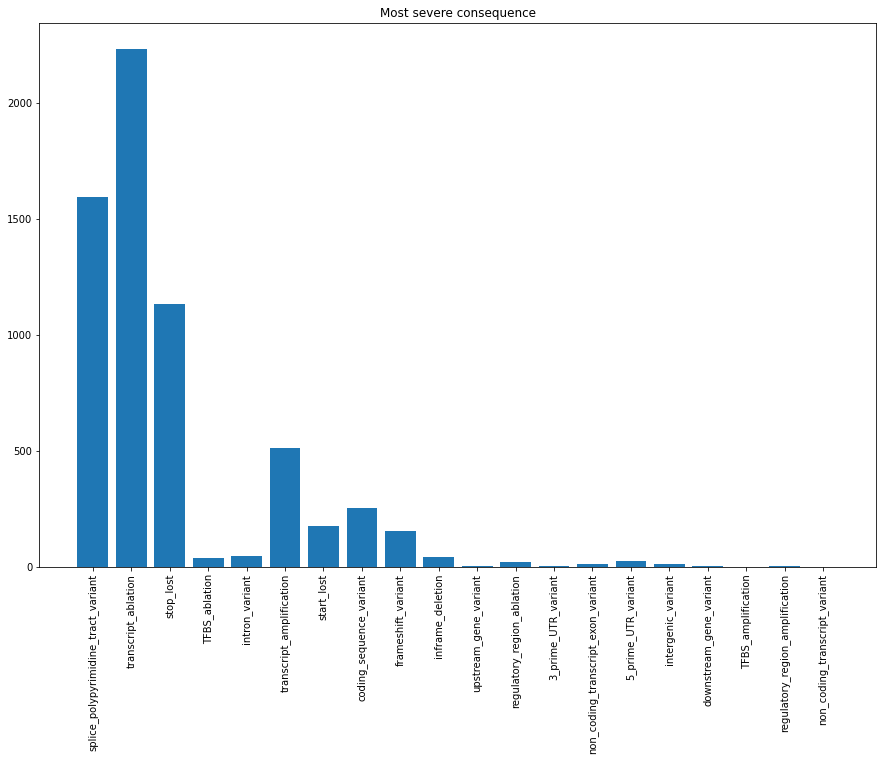

In [333]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='vertical')
plt.title(f'Most severe consequence')
plt.bar(consequence_counts.keys(), consequence_counts.values())

In [332]:
consequence_counts

Counter({'splice_polypyrimidine_tract_variant': 1596,
         'transcript_ablation': 2234,
         'stop_lost': 1133,
         'TFBS_ablation': 39,
         'intron_variant': 47,
         'transcript_amplification': 513,
         'start_lost': 177,
         'coding_sequence_variant': 252,
         'frameshift_variant': 154,
         'inframe_deletion': 41,
         'upstream_gene_variant': 3,
         'regulatory_region_ablation': 22,
         '3_prime_UTR_variant': 5,
         'non_coding_transcript_exon_variant': 12,
         '5_prime_UTR_variant': 24,
         'intergenic_variant': 12,
         'downstream_gene_variant': 2,
         'TFBS_amplification': 1,
         'regulatory_region_amplification': 2,
         'non_coding_transcript_variant': 1})

In [52]:
def gene_counts(dataset, limit=None):
    vep_results = get_vep_results(dataset, limit)
        
    hgvs_to_genes = extract_genes(vep_results)
    print(f'{len(hgvs_to_genes)} successfully mapped by VEP')
    
    return hgvs_to_genes, [len(y) for x,y in hgvs_to_genes.items()]

In [54]:
hgvs_to_genes, counts = gene_counts(dataset)

13619 records processed
17395 HGVS expressions
6583 parsed into chrom/start/end/type
6270 successfully mapped by VEP


In [303]:
print('Mean:', np.mean(counts))
print('Median:', np.median(counts))
print('Min:', np.min(counts))
print('Max:', np.max(counts))

Mean: 4.137480063795853
Median: 2.0
Min: 0
Max: 437


In [318]:
MAX_REASONABLE_COUNT = 50
smaller_counts = [x for x in counts if x < MAX_REASONABLE_COUNT]
print(len(smaller_counts))

6199


(array([7.600e+01, 2.698e+03, 1.568e+03, 7.890e+02, 4.070e+02, 1.520e+02,
        1.050e+02, 4.900e+01, 6.700e+01, 3.800e+01, 3.500e+01, 1.800e+01,
        1.700e+01, 9.000e+00, 1.500e+01, 1.600e+01, 9.000e+00, 9.000e+00,
        8.000e+00, 8.000e+00, 9.000e+00, 8.000e+00, 4.000e+00, 2.000e+00,
        4.000e+00, 2.000e+00, 5.000e+00, 8.000e+00, 2.000e+00, 5.000e+00,
        4.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 6.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        4.000e+00, 0.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 3.000e+00,
        7.000e+00, 2.000e+00]),
 array([ 0.  ,  0.98,  1.96,  2.94,  3.92,  4.9 ,  5.88,  6.86,  7.84,
         8.82,  9.8 , 10.78, 11.76, 12.74, 13.72, 14.7 , 15.68, 16.66,
        17.64, 18.62, 19.6 , 20.58, 21.56, 22.54, 23.52, 24.5 , 25.48,
        26.46, 27.44, 28.42, 29.4 , 30.38, 31.36, 32.34, 33.32, 34.3 ,
        35.28, 36.26, 37.24, 38.22, 39.2 , 40.18, 41.16, 42.14, 43.12,
        44.1 , 45.08,

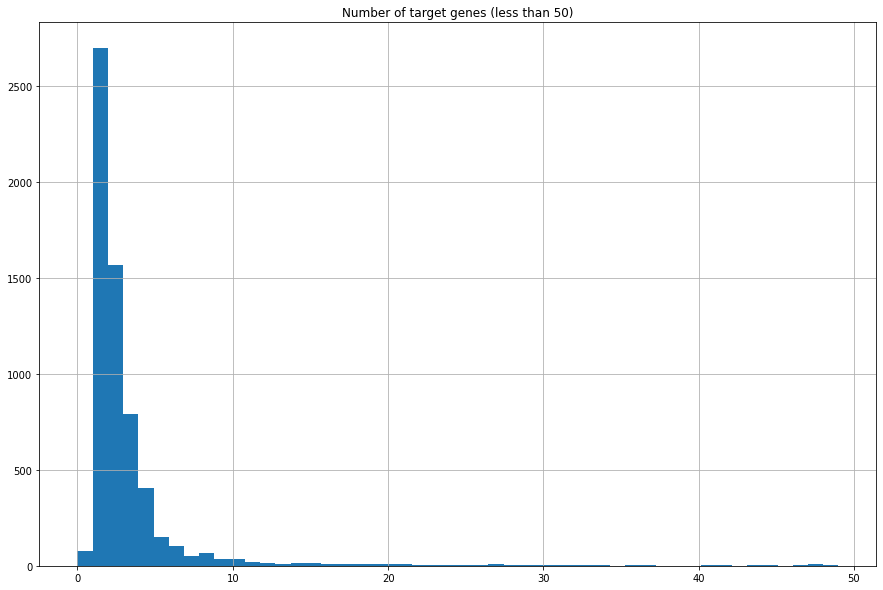

In [320]:
plt.figure(figsize=(15,10))
plt.grid(visible=True)
plt.title(f'Number of target genes (less than {MAX_REASONABLE_COUNT})')
# first array is counts per bin
# second array is left edges of bins, plus last right edge
plt.hist(smaller_counts, bins=min(100, MAX_REASONABLE_COUNT))

### Summary

* out of 11,000 with known minimum span, 6270 successfully mapped by VEP
* haven't fully tested how many HGVS are handled by VEP "out of the box"

### Questions

* check hgvs is always on the + strand
* how important is it to actually get the variant type, if we have chrom/start/end?
    * related, can we do anything about delins?
* what to do with sequences that aren't accepted by VEP as-is?
    - OK for VEP: `NC`, `LRG`, `NW`, `AC`
    - not OK:
        - `NG_*` genomic region - could map (?)
        - `hg38.chrX` and similar - could parse
        - `AF287270` - genomic region also?
        - `CM000663.1`
        - `L78833.1`

For OT
* should these have a different consequence type, as we do for repeat expansion?
* what's the cutoff we should use?
* dealing with uncertainty